# Image Analysis Notebook

This notebook performs a series of analyses on a dataset of categorized images.

## Analyses performed:
1.  **File Metadata:** Image dimensions, aspect ratio, and file size.
2.  **Low-Level Features:** Brightness, contrast, and sharpness.
3.  **Texture:** Homogeneity, energy, and correlation from GLCM.
4.  **Color:** Average color histograms and dominant color analysis.
5.  **SIFT Features:** Bag of Visual Words from SIFT descriptors.
6.  **Classification:** XGBoost model trained on all features.

In [15]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from skimage.feature import graycomatrix, graycoprops
from collections import Counter
from IPython.display import display
import torch
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import shutil

## Configuration
Set the data and output directories here.

In [16]:
data_dir = './tp1/data/1/dataset-resized'

## Helper Functions

In [17]:
def get_image_paths(data_dir: str) -> pd.DataFrame:
    """Gathers image paths and their categories from the data directory."""
    records = []
    for category_dir in Path(data_dir).iterdir():
        if not category_dir.is_dir():
            continue
        category = category_dir.name
        for image_path in category_dir.iterdir():
            if image_path.suffix.lower() in ['.png', '.jpg', '.jpeg']:
                records.append({'path': str(image_path), 'category': category})
    return pd.DataFrame(records)

def plot_distribution(df: pd.DataFrame, column: str, title: str):
    """Plots the distribution of a given column, grouped by category."""
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df, x='category', y=column, palette='Set2')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Analysis Functions

In [18]:
def analyze_file_metadata(df: pd.DataFrame) -> pd.DataFrame:
    """Analyzes image dimensions and file sizes."""
    print("Analyzing file metadata (dimensions, file size)...")
    metadata = []
    for path in df['path']:
        p = Path(path)
        try:
            file_size = p.stat().st_size
            img = cv2.imread(str(p))
            if img is not None:
                height, width, _ = img.shape
                aspect_ratio = width / height
                metadata.append({
                    'width': width, 'height': height, 'aspect_ratio': aspect_ratio,
                    'file_size_kb': file_size / 1024
                })
            else:
                metadata.append({'width': None, 'height': None, 'aspect_ratio': None, 'file_size_kb': None})
        except Exception as e:
            print(f"Could not read metadata for {p}: {e}")
            metadata.append({'width': None, 'height': None, 'aspect_ratio': None, 'file_size_kb': None})
            
    return df.join(pd.DataFrame(metadata, index=df.index)).dropna()


def analyze_low_level_features(df: pd.DataFrame) -> pd.DataFrame:
    """Analyzes brightness, contrast, and sharpness."""
    print("Analyzing low-level features (brightness, contrast, sharpness)...")
    features = []
    for path in df['path']:
        try:
            img = cv2.imread(path)
            if img is not None:
                gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                brightness = gray_img.mean()
                contrast = gray_img.std()
                sharpness = cv2.Laplacian(gray_img, cv2.CV_64F).var()
                features.append({'brightness': brightness, 'contrast': contrast, 'sharpness': sharpness})
            else:
                features.append({'brightness': None, 'contrast': None, 'sharpness': None})
        except Exception as e:
            print(f"Could not analyze low-level features for {path}: {e}")
            features.append({'brightness': None, 'contrast': None, 'sharpness': None})
            
    return df.join(pd.DataFrame(features, index=df.index)).dropna()


def analyze_texture(df: pd.DataFrame) -> pd.DataFrame:
    """Analyzes texture features using GLCM."""
    print("Analyzing texture features...")
    texture_features = []
    for path in df['path']:
        try:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                glcm = graycomatrix(img, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
                homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
                energy = graycoprops(glcm, 'energy')[0, 0]
                correlation = graycoprops(glcm, 'correlation')[0, 0]
                texture_features.append({'homogeneity': homogeneity, 'energy': energy, 'correlation': correlation})
            else:
                texture_features.append({'homogeneity': None, 'energy': None, 'correlation': None})
        except Exception as e:
            print(f"Could not analyze texture for {path}: {e}")
            texture_features.append({'homogeneity': None, 'energy': None, 'correlation': None})
            
    return df.join(pd.DataFrame(texture_features, index=df.index)).dropna()


def analyze_dominant_colors(df: pd.DataFrame, n_colors: int = 3) -> pd.DataFrame:
    """Finds the N dominant colors in each image using KMeans clustering."""
    print(f"Analyzing dominant colors (top {n_colors})...")
    
    dominant_colors_data = []
    
    for path in df['path']:
        img = cv2.imread(path)
        if img is None:
            colors = {}
            for i in range(n_colors):
                colors[f'dom_color_{i+1}_r'] = None
                colors[f'dom_color_{i+1}_g'] = None
                colors[f'dom_color_{i+1}_b'] = None
            dominant_colors_data.append(colors)
            continue
            
        # Convert to RGB and reshape for KMeans
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pixels = np.float32(img_rgb.reshape((-1, 3)))
        
        try:
            # Using KMeans to find dominant colors
            kmeans = MiniBatchKMeans(n_clusters=n_colors, random_state=42, n_init='auto')
            kmeans.fit(pixels)
            
            # Get the colors and sort them by prevalence
            rgb_colors = kmeans.cluster_centers_.astype(int)
            _, counts = np.unique(kmeans.labels_, return_counts=True)
            sorted_indices = np.argsort(-counts)
            sorted_rgb_colors = rgb_colors[sorted_indices]
            
            # Store as a dictionary, flattened
            colors = {}
            for i in range(n_colors):
                colors[f'dom_color_{i+1}_r'] = sorted_rgb_colors[i][0]
                colors[f'dom_color_{i+1}_g'] = sorted_rgb_colors[i][1]
                colors[f'dom_color_{i+1}_b'] = sorted_rgb_colors[i][2]
            dominant_colors_data.append(colors)
        except Exception as e:
            print(f"Could not analyze dominant colors for {path}: {e}")
            colors = {}
            for i in range(n_colors):
                colors[f'dom_color_{i+1}_r'] = None
                colors[f'dom_color_{i+1}_g'] = None
                colors[f'dom_color_{i+1}_b'] = None
            dominant_colors_data.append(colors)
            
    return df.join(pd.DataFrame(dominant_colors_data, index=df.index)).dropna()


def analyze_sift_features(df: pd.DataFrame, vocabulary_size: int = 100) -> pd.DataFrame:
    """Extracts SIFT features using a bag of visual words model."""
    print(f"Analyzing SIFT features with vocabulary size {vocabulary_size}...")
    sift = cv2.SIFT_create()
    
    # 1. Extract descriptors from all images to build vocabulary
    all_descriptors = []
    
    print("Extracting SIFT descriptors for vocabulary...")
    for path in df['path']:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            _, descriptors = sift.detectAndCompute(img, None)
            if descriptors is not None:
                all_descriptors.append(descriptors)

    if not all_descriptors:
        print("No SIFT descriptors found to build vocabulary.")
        sift_cols = [f'sift_{i}' for i in range(vocabulary_size)]
        return pd.DataFrame(np.nan, index=df.index, columns=sift_cols)

    all_descriptors_np = np.vstack(all_descriptors)
    
    # 2. Build vocabulary using KMeans
    print(f"Building vocabulary with {len(all_descriptors_np)} descriptors...")
    kmeans = MiniBatchKMeans(n_clusters=vocabulary_size, random_state=42, batch_size=256*4, n_init='auto')
    kmeans.fit(all_descriptors_np)
    
    # 3. Create histograms for each image
    print("Creating feature histograms for each image...")
    histograms = []
    for path in df['path']:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        hist = np.zeros(vocabulary_size)
        if img is not None:
            _, descriptors = sift.detectAndCompute(img, None)
            if descriptors is not None:
                words = kmeans.predict(descriptors)
                for word in words:
                    hist[word] += 1
        if np.sum(hist) > 0:
            hist = hist / np.sum(hist)
        histograms.append(hist)
        
    sift_features_df = pd.DataFrame(histograms, index=df.index).add_prefix('sift_')
    return sift_features_df


def plot_average_color_histogram(df: pd.DataFrame):
    """Calculates and plots the average color histogram for each category."""
    print("Plotting average color histograms...")
    categories = df['category'].unique()
    colors = ('b', 'g', 'r')

    for category in categories:
        plt.figure(figsize=(12, 8))
        avg_hist = np.zeros((256, len(colors)))
        
        category_paths = df[df['category'] == category]['path']
        image_count = 0
        for path in category_paths:
            img = cv2.imread(path)
            if img is not None:
                for i, color in enumerate(colors):
                    hist = cv2.calcHist([img], [i], None, [256], [0, 256])
                    avg_hist[:, i] += hist.flatten()
                image_count += 1
        
        if image_count > 0:
            avg_hist /= image_count
            
        for i, color in enumerate(colors):
            plt.plot(avg_hist[:, i], color=color, label=f'{color.upper()} channel')
        
        plt.title(f'Average Color Histogram for Category: {category}')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Normalized Frequency')
        plt.legend()
        plt.grid(True)
        plt.show()

## Run Analysis

### 1. Get Image Paths

In [19]:
df = get_image_paths(data_dir)
if df.empty:
    print(f"No images found in {data_dir}. Exiting.")
else:
    print(f"Found {len(df)} images in {len(df['category'].unique())} categories.")
    display(df.head())

Found 2527 images in 6 categories.


,path,category
0,tp1/data/1/dataset-resized/cardboard/cardboard...,cardboard
1,tp1/data/1/dataset-resized/cardboard/cardboard...,cardboard
2,tp1/data/1/dataset-resized/cardboard/cardboard...,cardboard
3,tp1/data/1/dataset-resized/cardboard/cardboard...,cardboard
4,tp1/data/1/dataset-resized/cardboard/cardboard...,cardboard


### 2. Analyze and Plot Basic Metadata

Analyzing file metadata (dimensions, file size)...


/tmp/ipykernel_329242/1166995851.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y=column, palette='Set2')


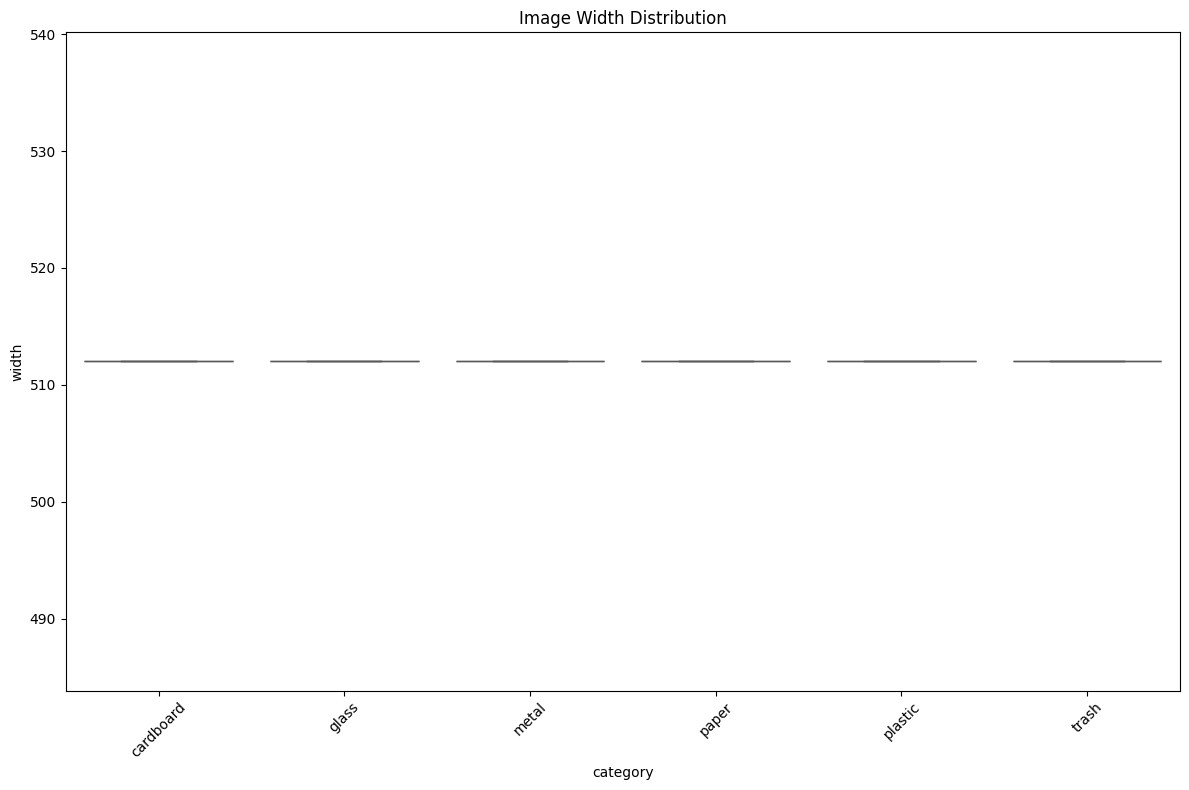

/tmp/ipykernel_329242/1166995851.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y=column, palette='Set2')


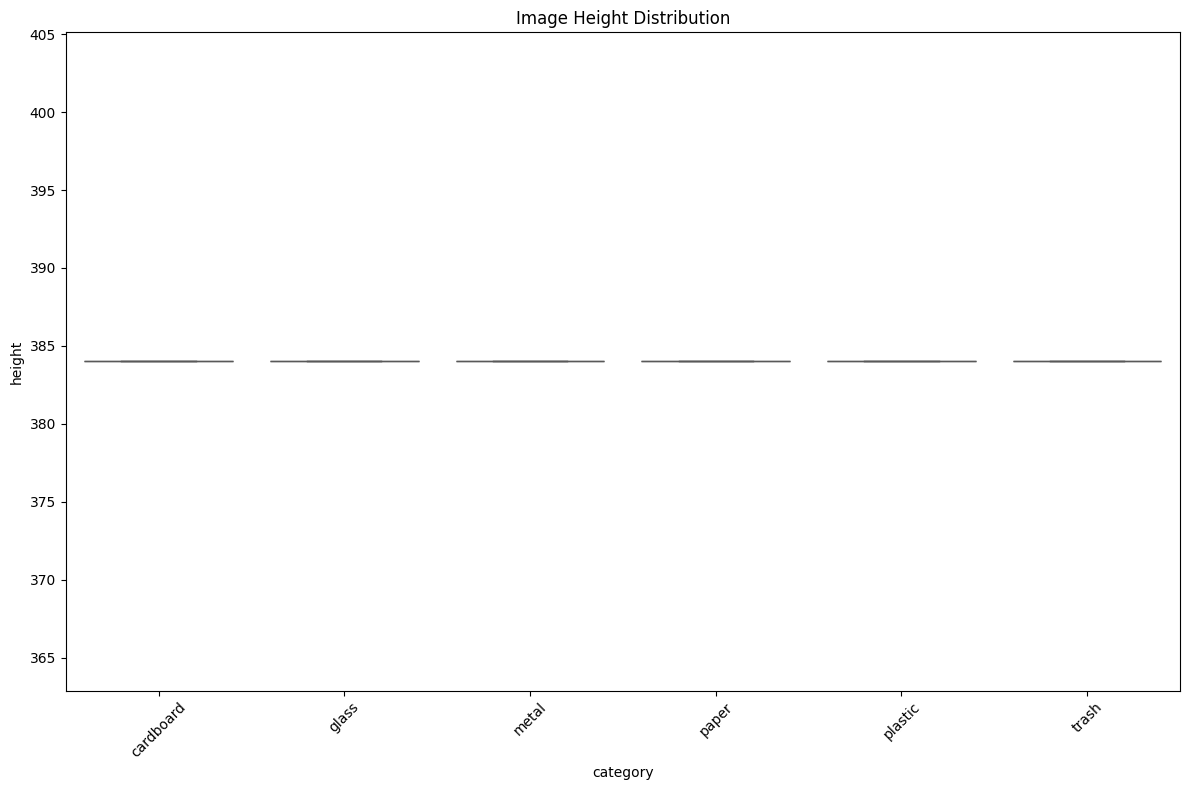

/tmp/ipykernel_329242/1166995851.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y=column, palette='Set2')


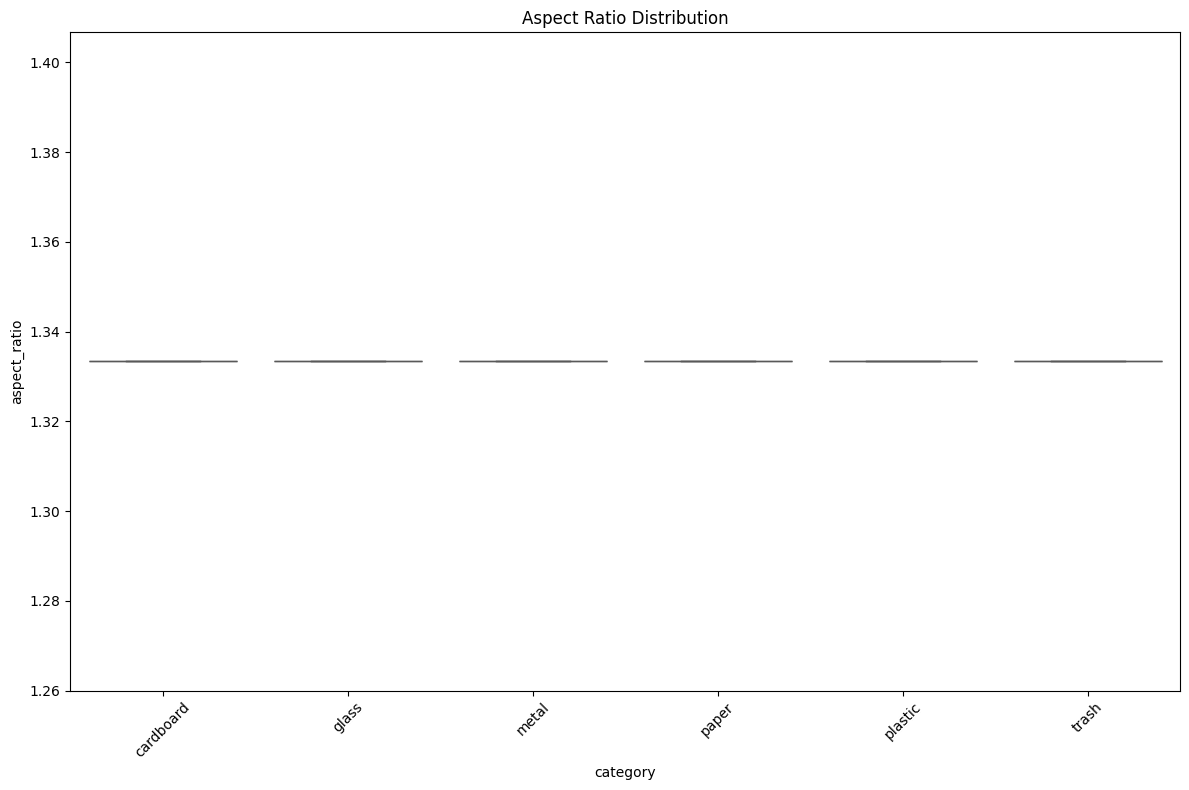

/tmp/ipykernel_329242/1166995851.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y=column, palette='Set2')


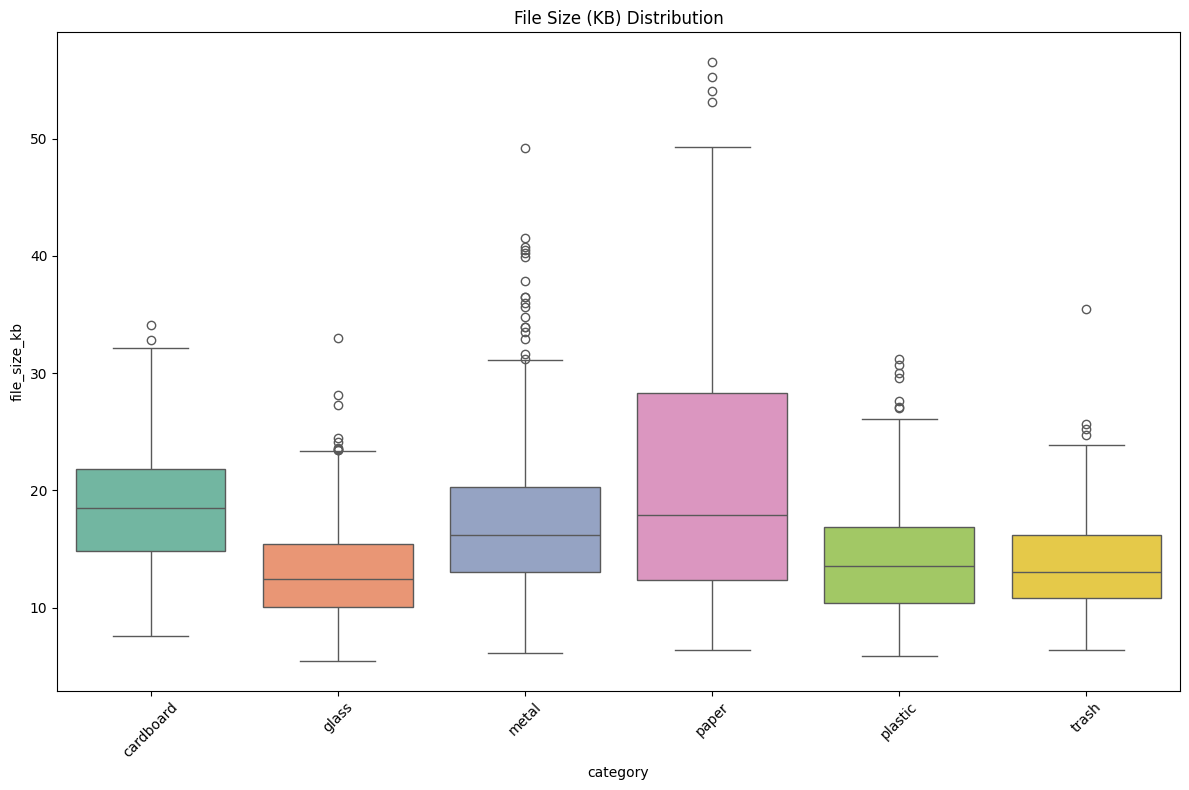

,path,category,width,height,aspect_ratio,file_size_kb
0,tp1/data/1/dataset-resized/cardboard/cardboard...,cardboard,512,384,1.333333,16.926758
1,tp1/data/1/dataset-resized/cardboard/cardboard...,cardboard,512,384,1.333333,21.174805
2,tp1/data/1/dataset-resized/cardboard/cardboard...,cardboard,512,384,1.333333,14.535156
3,tp1/data/1/dataset-resized/cardboard/cardboard...,cardboard,512,384,1.333333,13.954102
4,tp1/data/1/dataset-resized/cardboard/cardboard...,cardboard,512,384,1.333333,17.592773


In [20]:
if not df.empty:
    df_meta = analyze_file_metadata(df.copy())
    plot_distribution(df_meta, 'width', 'Image Width Distribution')
    plot_distribution(df_meta, 'height', 'Image Height Distribution')
    plot_distribution(df_meta, 'aspect_ratio', 'Aspect Ratio Distribution')
    plot_distribution(df_meta, 'file_size_kb', 'File Size (KB) Distribution')
    display(df_meta.head())

### 3. Analyze and Plot Low-Level Visual Features

In [ ]:
if not df.empty:
    df_low_level = analyze_low_level_features(df.copy())
    plot_distribution(df_low_level, 'brightness', 'Brightness Distribution')
    plot_distribution(df_low_level, 'contrast', 'Contrast Distribution')
    plot_distribution(df_low_level, 'sharpness', 'Sharpness (Laplacian Variance) Distribution')
    display(df_low_level.head())

### 4. Analyze and Plot Texture

In [ ]:
if not df.empty:
    df_texture = analyze_texture(df.copy())
    plot_distribution(df_texture, 'homogeneity', 'Texture Homogeneity Distribution')
    plot_distribution(df_texture, 'energy', 'Texture Energy Distribution')
    plot_distribution(df_texture, 'correlation', 'Texture Correlation Distribution')
    display(df_texture.head())

### 5. Analyze Dominant Colors

In [ ]:
if not df.empty:
    df_dominant_colors = analyze_dominant_colors(df.copy(), n_colors=3)
    display(df_dominant_colors.head())

### 6. Plot Color Histograms

In [ ]:
if not df.empty:
    plot_average_color_histogram(df)
    print("\nPlotting complete. Plots are displayed inline.")

## 7. Feature Loading & Extraction

This section loads the pre-compiled feature dataframe from `all_features.csv` if it exists. Otherwise, it runs all the feature extraction functions and saves the result to the cache file.

In [9]:
if not df.empty:
    features_cache_path = 'all_features.csv'
    
    if os.path.exists(features_cache_path):
        print(f"Loading features from cache: {features_cache_path}")
        all_features_df = pd.read_csv(features_cache_path)
    else:
        print("Cache not found. Extracting features...")
        # Chain all feature extraction steps to get a consolidated DataFrame.
        features_df = analyze_file_metadata(df.copy())
        features_df = analyze_low_level_features(features_df)
        features_df = analyze_texture(features_df)
        features_df = analyze_dominant_colors(features_df, n_colors=3)

        # Extract SIFT features
        sift_features = analyze_sift_features(features_df)
        
        # Combine all features
        all_features_df = features_df.join(sift_features)
        
        # Drop rows with any NaNs that might have been produced
        all_features_df.dropna(inplace=True)
        
        print(f"Saving features to cache: {features_cache_path}")
        all_features_df.to_csv(features_cache_path, index=False)
    
    print(f"\nLoaded {len(all_features_df)} images with {len(all_features_df.columns) - 2} features.")
    display(all_features_df.head())

Loading features from cache: all_features.csv

Loaded 2527 images with 119 features.


,path,category,width,height,aspect_ratio,file_size_kb,brightness,contrast,sharpness,homogeneity,...,sift_90,sift_91,sift_92,sift_93,sift_94,sift_95,sift_96,sift_97,sift_98,sift_99
0,tp1/data/1/dataset-resized/cardboard/cardboard...,cardboard,512,384,1.333333,16.926758,162.234172,31.875892,79.261693,0.253940,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,tp1/data/1/dataset-resized/cardboard/cardboard...,cardboard,512,384,1.333333,21.174805,167.698283,38.799907,411.076231,0.208085,...,0.008850,0.004425,0.0,0.004425,0.006637,0.004425,0.0,0.008850,0.002212,0.002212
2,tp1/data/1/dataset-resized/cardboard/cardboard...,cardboard,512,384,1.333333,14.535156,182.280197,44.498372,225.419349,0.345957,...,0.004184,0.004184,0.0,0.012552,0.000000,0.008368,0.0,0.008368,0.008368,0.000000
3,tp1/data/1/dataset-resized/cardboard/cardboard...,cardboard,512,384,1.333333,13.954102,130.963028,68.561937,21.528351,0.290627,...,0.000000,0.000000,0.0,0.020833,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,tp1/data/1/dataset-resized/cardboard/cardboard...,cardboard,512,384,1.333333,17.592773,165.178823,45.320633,91.037846,0.196038,...,0.000000,0.010753,0.0,0.021505,0.000000,0.000000,0.0,0.010753,0.000000,0.000000


## 8. Dimensionality Reduction and Visualization

We use PCA and t-SNE to reduce the dimensionality of the feature set to 2D for visualization. This helps to visually inspect how well-separated the different categories are based on the extracted features.

Two t-SNE plots are generated: one with the full feature set, and one excluding the high-dimensional SIFT features to see the influence of the other engineered features more clearly.

In [ ]:
if not df.empty:
    print("\n--- Performing Dimensionality Reduction ---")
    
    # Prepare data for plotting
    plot_y_dr = all_features_df['category']
    plot_X_dr = all_features_df.drop(columns=['path', 'category'])
    
    # Normalize features before dimensionality reduction
    print("Normalizing features...")
    scaler = StandardScaler()
    plot_X_dr_scaled = scaler.fit_transform(plot_X_dr)
    
    # PCA
    print("Running PCA...")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(plot_X_dr_scaled)
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=plot_y_dr, palette='Set2', s=50, alpha=0.7)
    plt.title('PCA of Feature Matrix')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.show()

    # t-SNE
    tsne_cache_path = 'tsne_results.npy'
    print("\nRunning t-SNE... (this may take a while)")
    # Perplexity must be less than n_samples
    perplexity_value = min(30, len(plot_X_dr_scaled) - 1)
    if perplexity_value > 0:
        if os.path.exists(tsne_cache_path):
            print(f"Loading t-SNE results from cache: {tsne_cache_path}")
            X_tsne = np.load(tsne_cache_path)
        else:
            print("Cache not found. Calculating t-SNE...")
            tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
            X_tsne = tsne.fit_transform(plot_X_dr_scaled)
            print(f"Saving t-SNE results to cache: {tsne_cache_path}")
            np.save(tsne_cache_path, X_tsne)
        
        plt.figure(figsize=(12, 8))
        sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=plot_y_dr, palette='Set2', s=50, alpha=0.7)
        plt.title('t-SNE of Feature Matrix')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping t-SNE plot due to insufficient samples.")

    # t-SNE on features without SIFT
    tsne_cache_path_no_sift = 'tsne_results_no_sift.npy'
    print("\nRunning t-SNE on features without SIFT... (this may take a while)")
    plot_X_dr_no_sift = plot_X_dr.filter(regex=r'^(?!sift_).*')

    # Normalize the non-SIFT features separately
    scaler_no_sift = StandardScaler()
    plot_X_dr_no_sift_scaled = scaler_no_sift.fit_transform(plot_X_dr_no_sift)

    # Perplexity must be less than n_samples
    perplexity_value_no_sift = min(30, len(plot_X_dr_no_sift_scaled) - 1)
    if perplexity_value_no_sift > 0:
        if os.path.exists(tsne_cache_path_no_sift):
            print(f"Loading non-SIFT t-SNE results from cache: {tsne_cache_path_no_sift}")
            X_tsne_no_sift = np.load(tsne_cache_path_no_sift)
        else:
            print("Cache not found. Calculating non-SIFT t-SNE...")
            tsne_no_sift = TSNE(n_components=2, random_state=42, perplexity=perplexity_value_no_sift)
            X_tsne_no_sift = tsne_no_sift.fit_transform(plot_X_dr_no_sift_scaled)
            print(f"Saving non-SIFT t-SNE results to cache: {tsne_cache_path_no_sift}")
            np.save(tsne_cache_path_no_sift, X_tsne_no_sift)
        
        plt.figure(figsize=(12, 8))
        sns.scatterplot(x=X_tsne_no_sift[:, 0], y=X_tsne_no_sift[:, 1], hue=plot_y_dr, palette='Set2', s=50, alpha=0.7)
        plt.title('t-SNE of Feature Matrix (excluding SIFT)')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping non-SIFT t-SNE plot due to insufficient samples.")

## 9. Model Training with XGBoost

This section trains the XGBoost classifier on the full feature set. The model will be trained using CUDA if a compatible GPU and XGBoost installation are available.


Training XGBoost model with GPU...


/home/leocenturion/Documents/postgrados/ia/cv2/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:10:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/leocenturion/Documents/postgrados/ia/cv2/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:10:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Evaluating model...
Model Accuracy: 0.7510

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.87      0.78      0.82       121
       glass       0.64      0.74      0.69       151
       metal       0.71      0.64      0.68       123
       paper       0.85      0.88      0.87       178
     plastic       0.71      0.76      0.74       145
       trash       0.66      0.46      0.54        41

    accuracy                           0.75       759
   macro avg       0.74      0.71      0.72       759
weighted avg       0.75      0.75      0.75       759



/home/leocenturion/Documents/postgrados/ia/cv2/.venv/lib/python3.13/site-packages/xgboost/core.py:2676: UserWarning: [21:10:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/home/leocenturion/Documents/postgrados/ia/cv2/.venv/lib/python3.13/site-packages/xgboost/core.py:729: UserWarning: [21:10:22] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


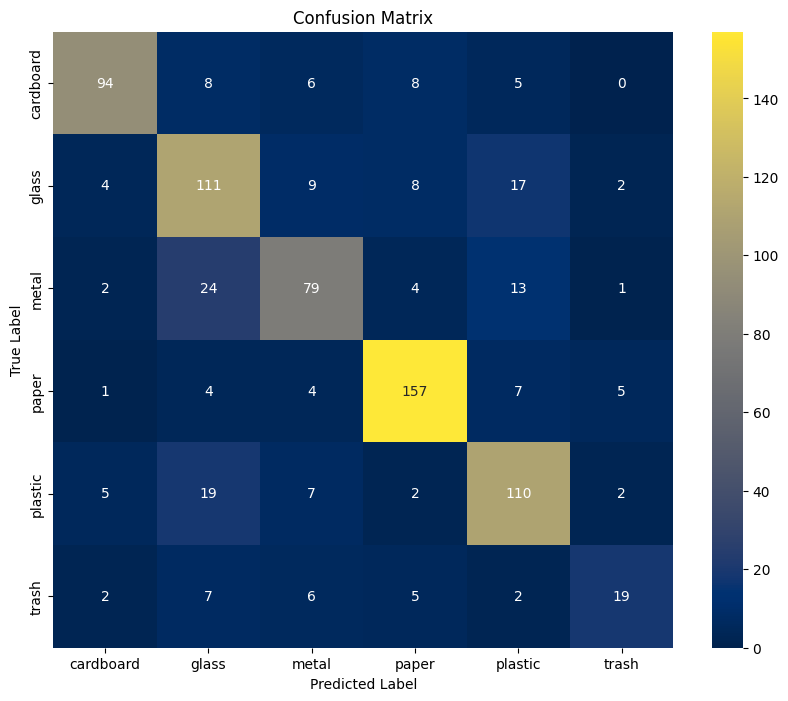

In [11]:
if not df.empty:
    # Prepare data for XGBoost
    y = all_features_df['category']
    X = all_features_df.drop(columns=['path', 'category'])

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
    
    # Train XGBoost model
    print("\nTraining XGBoost model with GPU...")
    model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')
    model.fit(X_train, y_train)
    
    # Evaluate model
    print("\nEvaluating model...")
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='cividis')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## 10. Misclassification Analysis

Here we analyze the feature distributions for correctly and incorrectly classified images to understand what might be causing errors.

In [ ]:
# Get predictions for the training set as well
y_pred_train = model.predict(X_train)

# Combine train and test data for analysis, including paths
X_train_with_paths = X_train.copy()
X_train_with_paths['path'] = all_features_df.loc[X_train.index, 'path'].values
X_test_with_paths = X_test.copy()
X_test_with_paths['path'] = all_features_df.loc[X_test.index, 'path'].values

results_df = pd.concat([X_train_with_paths, X_test_with_paths], ignore_index=True)
results_df['true_label'] = np.concatenate([y_train, y_test])
results_df['predicted_label'] = np.concatenate([y_pred_train, y_pred])
results_df['status'] = np.where(results_df['true_label'] == results_df['predicted_label'], 'Correct', 'Misclassified')

# Print and copy misclassified image paths
print("\n--- Misclassified Image Paths & Copying Files ---")
misclassified_df = results_df[results_df['status'] == 'Misclassified'].copy()
misclassified_df['true_category'] = le.inverse_transform(misclassified_df['true_label'])
misclassified_df['predicted_category'] = le.inverse_transform(misclassified_df['predicted_label'])

# Create base directory for misclassified images
misclassified_dir = Path('misclassified')
misclassified_dir.mkdir(exist_ok=True)
print(f"Copying misclassified images to '{misclassified_dir}' directory...")

for category_name, group in misclassified_df.groupby('true_category'):
    print(f"\nImages MISCLASSIFIED from category: '{category_name}'")
    
    # Create subdirectory for the category
    category_subdir = misclassified_dir / category_name
    category_subdir.mkdir(exist_ok=True)
    
    for _, row in group.iterrows():
        source_path = Path(row['path'])
        dest_path = category_subdir / source_path.name
        print(f"  - Path: {row['path']} (Predicted as: '{row['predicted_category']}') -> Copying to {dest_path}")
        shutil.copy(source_path, dest_path)


# Identify feature columns to plot
feature_cols = X_train.columns

print(f"\nAnalyzing feature distributions for {len(results_df[results_df['status'] == 'Misclassified'])} misclassified images...")

for feature in feature_cols:
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=results_df, x='status', y=feature, palette='Set2')
    plt.title(f'Distribution of "{feature}" for Correct vs. Misclassified Images')
    plt.show()

## 11. Fine-Tuning ResNet-50

This section fine-tunes a pre-trained ResNet-50 model from Hugging Face on our dataset. We replace the original classification head with a new one tailored to our specific categories. The model's base layers are frozen, and only the new head is trained for a few epochs. This technique, known as transfer learning, is efficient and effective for adapting large models to specialized tasks.

Loading ResNet-50 model and replacing classification head...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([6, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on cuda.

--- Fine-tuning the classification head ---


Epoch 1/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:08<00:00,  6.95it/s, loss=1.5622]


Epoch 1 - Average Training Loss: 1.6119


Epoch 2/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:07<00:00,  7.77it/s, loss=1.5231]


Epoch 2 - Average Training Loss: 1.3886


Epoch 3/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:07<00:00,  7.84it/s, loss=1.0807]


Epoch 3 - Average Training Loss: 1.2317

--- Evaluating the fine-tuned model ---


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  6.27it/s]
/home/leocenturion/Documents/postgrados/ia/cv2/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/leocenturion/Documents/postgrados/ia/cv2/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/leocentur

Fine-tuned ResNet-50 Accuracy: 0.6891

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.81      0.73      0.77       121
       glass       0.69      0.72      0.71       151
       metal       0.73      0.54      0.62       123
       paper       0.60      0.94      0.73       178
     plastic       0.75      0.63      0.69       145
       trash       0.00      0.00      0.00        41

    accuracy                           0.69       759
   macro avg       0.60      0.59      0.59       759
weighted avg       0.67      0.69      0.67       759



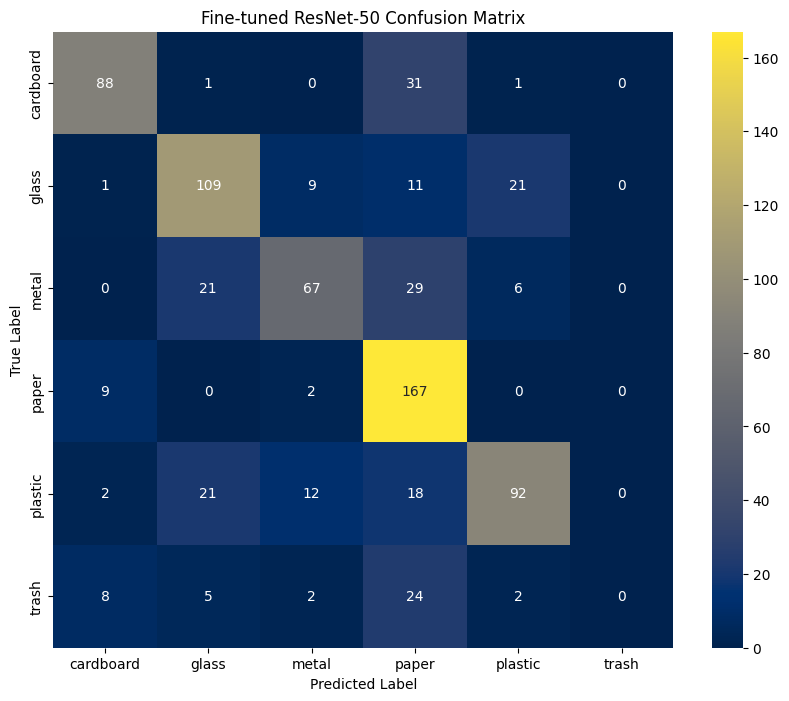

In [12]:
if not df.empty:
    import copy
    from torch.utils.data import Dataset, DataLoader
    from torch.optim import AdamW
    from tqdm.auto import tqdm # For progress bars
    
    # 1. Create a custom PyTorch Dataset
    class ImageClassificationDataset(Dataset):
        def __init__(self, df, processor, label_encoder):
            self.df = df
            self.processor = processor
            self.label_encoder = label_encoder

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            image_path = row['path']
            image = Image.open(image_path).convert("RGB")
            
            # The processor returns a dict with 'pixel_values'
            inputs = self.processor(images=image, return_tensors="pt")
            pixel_values = inputs['pixel_values'].squeeze(0) # Remove batch dimension
            
            label = self.label_encoder.transform([row['category']])[0]
            
            return pixel_values, label

    # 2. Load ResNet-50 and replace the classification head
    print("Loading ResNet-50 model and replacing classification head...")
    num_labels = len(le.classes_)
    processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
    model = AutoModelForImageClassification.from_pretrained(
        "microsoft/resnet-50", 
        num_labels=num_labels, 
        id2label={i: label for i, label in enumerate(le.classes_)},
        label2id={label: i for i, label in enumerate(le.classes_)},
        ignore_mismatched_sizes=True # This allows replacing the head
    )
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    print(f"Model loaded on {device}.")
    
    # 3. Prepare data loaders
    # Use the same train/test split from the XGBoost section
    train_df = all_features_df.loc[X_train.index]
    test_df = all_features_df.loc[X_test.index]
    
    train_dataset = ImageClassificationDataset(train_df, processor, le)
    test_dataset = ImageClassificationDataset(test_df, processor, le)
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=os.cpu_count())
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=os.cpu_count())
    
    # 4. Fine-tune the model
    # Freeze base layers and train only the classifier
    for param in model.base_model.parameters():
        param.requires_grad = False
        
    optimizer = AdamW(model.classifier.parameters(), lr=5e-4)
    loss_fn = torch.nn.CrossEntropyLoss()
    num_epochs = 3

    # Early stopping parameters
    patience = 2
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_weights = None

    print("\n--- Fine-tuning the classification head ---")
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")
        for batch in progress_bar:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(pixel_values=inputs)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch+1} - Average Training Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            val_progress_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)")
            for batch in val_progress_bar:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(pixel_values=inputs)
                loss = loss_fn(outputs.logits, labels)
                total_val_loss += loss.item()
                val_progress_bar.set_postfix({'val_loss': f'{loss.item():.4f}'})

        avg_val_loss = total_val_loss / len(test_loader)
        print(f"Epoch {epoch+1} - Average Validation Loss: {avg_val_loss:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_weights = copy.deepcopy(model.state_dict())
            print("Validation loss improved. Saving model.")
        else:
            epochs_no_improve += 1
            print(f"Validation loss did not improve. Patience: {epochs_no_improve}/{patience}")

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break
            
    # Load best model weights before evaluation
    if best_model_weights:
        print("Loading best model weights for evaluation.")
        model.load_state_dict(best_model_weights)

    # 5. Evaluate the fine-tuned model
    print("\n--- Evaluating the fine-tuned model ---")
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = batch
            inputs = inputs.to(device)
            
            outputs = model(pixel_values=inputs)
            preds = torch.argmax(outputs.logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    y_true_resnet_tuned = all_labels
    y_pred_resnet_tuned = all_preds

    accuracy = accuracy_score(y_true_resnet_tuned, y_pred_resnet_tuned)
    print(f"Fine-tuned ResNet-50 Accuracy: {accuracy:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true_resnet_tuned, y_pred_resnet_tuned, target_names=le.classes_))

    cm = confusion_matrix(y_true_resnet_tuned, y_pred_resnet_tuned)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='cividis')
    plt.title('Fine-tuned ResNet-50 Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [13]:
print(model)

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

ModuleNotFoundError: No module named 'torchviz'